In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,roc_curve,precision_recall_curve, average_precision_score,
                           mean_squared_error, mean_absolute_error, r2_score, accuracy_score)
from sklearn.calibration import calibration_curve
import statsmodels.api as sm
import shap

# Load data
print("Loading data...")
filtered_df = pd.read_csv("filtered_df.csv")
filtered_df = filtered_df[(filtered_df['gestfips']==34) | (filtered_df['gestfips']==36)]

# Define features and target
X = filtered_df[['hehousut','hetelhhd','hetelavl','hefaminc','hrnumhou','hrhtype',
                'HUBUS','gereg','gediv','gestfips','gtcbsa','gtco','gtcbsast',
                'gtmetsta','gtindvpc','gtcbsasz','gtcsa','perrp','prtage','pemaritl',
                'pesex','peeduca','ptdtrace','prdthsp','PUCHINHH','prfamrel',
                'prfamtyp','pehspnon','penatvty','pemntvty','pefntvty','prcitshp',
                'prinuyer','PUWK','pemjot','pemjnum','pehruslt','pehractt',
                'peio1cow','prdtind1','prdtocc1','pternwa','ptwk','prchld','prnmchld']]
y = filtered_df['pttlwk']
y = (y == 1.0).astype(int)

print(f"Data shape: X = {X.shape}, y = {y.shape}")

Loading data...
Data shape: X = (17819, 45), y = (17819,)


In [ ]:
# Define continuous columns
continuous_columns = [
    'hrnumhou',   # Number of persons living in household
    'prtage',     # Age
    'pemjnum',    # Number of jobs
    'pehruslt',   # Usual hours worked
    'pehractt',   # Actual hours worked last week
    'pternwa',    # Weekly earnings
    'prnmchld'    # Number of own children
]
def create_dummies_with_base(df, continuous_cols):
    """Create dummy variables while preserving continuous features and dropping base categories"""
    print("\nCreating dummy variables...")
    df_processed = df.copy()
    dummies_list = []

    for column in df_processed.columns:
        if column in continuous_cols:
            # Convert to numeric without filling missing values
            df_processed[column] = pd.to_numeric(df_processed[column], errors='coerce')
            dummies_list.append(df_processed[[column]])
        else:
            # Create dummies with drop_first=True to avoid dummy variable trap
            df_temp = df_processed[column].copy()
            df_temp = df_temp.map(lambda x: str(x) if pd.notnull(x) and
                                (not isinstance(x, (int, float)) or x >= 0) else np.nan)
            dummies = pd.get_dummies(df_temp, prefix=f"{column}_dummy", drop_first=True)
            dummies_list.append(dummies)

            # Optionally, print the dropped base category
            if len(dummies.columns) > 0:
                base_category = df_temp.dropna().unique()[0]
                print(f"Dropped base category for {column}: {base_category}")

    final_df = pd.concat(dummies_list, axis=1)
    print(f"\nOriginal shape: {df.shape}")
    print(f"Final shape after dummy creation: {final_df.shape}")
    return final_df

# Create dummies with standardization
X_with_dummies = create_dummies_with_base(X, continuous_columns)

# Standardize continuous features
scaler = StandardScaler()
for column in continuous_columns:
    if column in X_with_dummies.columns:
        col_data = X_with_dummies[[column]].fillna(X_with_dummies[column].median())
        X_with_dummies[column] = scaler.fit_transform(col_data)

print(f"\nFinal shape after standardization: {X_with_dummies.shape}")


Creating dummy variables...
Dropped base category for hehousut: 1
Dropped base category for hetelhhd: 1
Dropped base category for hetelavl: 2
Dropped base category for hefaminc: 14
Dropped base category for hrhtype: 1
Dropped base category for HUBUS: 1
Dropped base category for gestfips: 34
Dropped base category for gtcbsa: 35620
Dropped base category for gtco: 3
Dropped base category for gtcbsast: 2
Dropped base category for gtmetsta: 1
Dropped base category for gtindvpc: 0
Dropped base category for gtcbsasz: 7
Dropped base category for gtcsa: 408
Dropped base category for perrp: 40.0
Dropped base category for pemaritl: 1.0
Dropped base category for pesex: 2.0
Dropped base category for peeduca: 44.0
Dropped base category for ptdtrace: 1.0
Dropped base category for prdthsp: 7.0
Dropped base category for PUCHINHH: 9.0
Dropped base category for prfamrel: 1.0
Dropped base category for prfamtyp: 1.0
Dropped base category for pehspnon: 2.0
Dropped base category for penatvty: 104.0
Dropped 

In [ ]:
# First, let's convert any boolean columns to numeric in X_with_dummies
for col in X_with_dummies.columns:
    if X_with_dummies[col].dtype == bool:
        X_with_dummies[col] = X_with_dummies[col].astype(int)
    elif X_with_dummies[col].dtype == 'object':
        X_with_dummies[col] = pd.to_numeric(X_with_dummies[col], errors='coerce')

In [ ]:
X_with_dummies

,hehousut_dummy_12,hehousut_dummy_2,hehousut_dummy_3,hehousut_dummy_4,hehousut_dummy_5,hehousut_dummy_6,hehousut_dummy_7,hetelhhd_dummy_2,hetelavl_dummy_2,hefaminc_dummy_10,...,prchld_dummy_15.0,prchld_dummy_2.0,prchld_dummy_3.0,prchld_dummy_4.0,prchld_dummy_5.0,prchld_dummy_6.0,prchld_dummy_7.0,prchld_dummy_8.0,prchld_dummy_9.0,prnmchld
651,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.534288
652,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.534288
653,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.534288
654,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.534288
655,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,-0.534288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318282,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,-0.534288
318283,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.534288
318284,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.534288
318399,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.534288


In [ ]:
# def calculate_vif_optimized(df, threshold=5):
#     """
#     Calculate VIF iteratively, removing highest VIF features until all are below threshold
#     Uses batch processing and early stopping for efficiency
#     """
#     print("\nCalculating VIF scores iteratively...")
#     numerical_df = df.select_dtypes(include=np.number).copy()

#     # Initialize variables
#     features_to_drop = []
#     max_vif = float('inf')

#     while len(numerical_df.columns) > 0 and max_vif > threshold:
#         # Calculate VIF in batches of 50 features
#         vif_data = []
#         batch_size = 50

#         for i in range(0, len(numerical_df.columns), batch_size):
#             batch_cols = numerical_df.columns[i:i + batch_size]
#             batch_df = numerical_df[batch_cols]

#             batch_vif = [
#                 (col, variance_inflation_factor(batch_df.values, j))
#                 for j, col in enumerate(batch_cols)
#             ]
#             vif_data.extend(batch_vif)

#         # Convert to DataFrame
#         vif_df = pd.DataFrame(vif_data, columns=['Feature', 'VIF'])

#         # Find highest VIF
#         max_vif_row = vif_df.loc[vif_df['VIF'].idxmax()]
#         max_vif = max_vif_row['VIF']

#         if max_vif > threshold:
#             feature_to_drop = max_vif_row['Feature']
#             features_to_drop.append(feature_to_drop)
#             numerical_df.drop(columns=[feature_to_drop], inplace=True)

#             # Print progress every 10 features
#             if len(features_to_drop) % 10 == 0:
#                 print(f"Dropped {len(features_to_drop)} features. Current max VIF: {max_vif:.2f}")

#     print(f"\nTotal features dropped: {len(features_to_drop)}")
#     return features_to_drop, vif_df

# # Calculate VIF and get features to drop
# high_vif_features, final_vif = calculate_vif_optimized(X_with_dummies, threshold=10)

# # Drop high VIF features
# X_clean = X_with_dummies.drop(columns=high_vif_features)

# # Print summary
# print("\nFinal VIF Results (top 10 highest):")
# print(final_vif.sort_values('VIF', ascending=False).head(10))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_with_dummies, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nFinal shapes after VIF and split:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")


Final shapes after VIF and split:
X_train: (14255, 684)
X_test: (3564, 684)


In [ ]:
#| label: probit
import statsmodels.api as sm
import numpy as np

print("\nFitting Probit model for effect sizes and p-values...")

# 1. Remove low variance columns
variance_threshold = 0.01  # Adjust this value as needed
variances = X_train.var()
low_variance_columns = variances[variances < variance_threshold].index
X_train_filtered = X_train.drop(columns=low_variance_columns)
print(f"Removed {len(low_variance_columns)} low variance columns")

# 2. Handle perfect multicollinearity
# Drop highly correlated features
def remove_highly_correlated_features(df, threshold=0.95):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop), to_drop

X_train_filtered, dropped_corr = remove_highly_correlated_features(X_train_filtered)
print(f"Removed {len(dropped_corr)} highly correlated features")

# 3. Add constant and fit model
X_train_probit = sm.add_constant(X_train_filtered)

# 4. Ensure all data is numeric
X_train_probit = X_train_probit.astype(float)

# 5. Fit Probit model with robust covariance
try:
    probit_model = sm.Probit(y_train, X_train_probit)
    probit_results = probit_model.fit(method='newton', cov_type='HC0')

    print("\nProbit Model Summary:")
    print(probit_results.summary())

    # Calculate marginal effects
    print("\nMarginal Effects (Probit):")
    marginal_effects = probit_results.get_margeff(at='overall')
    print(marginal_effects.summary())

    # Print top significant variables
    significant_vars = pd.DataFrame({
        'Variable': X_train_probit.columns,
        'Coefficient': probit_results.params,
        'Std Error': probit_results.bse,
        'Z-Score': probit_results.tvalues,
        'P-Value': probit_results.pvalues
    }).sort_values('P-Value')

    print("\nTop 10 Most Significant Variables:")
    print(significant_vars.head(10))

except Exception as e:
    print(f"Error in model fitting: {str(e)}")
    print("\nData shape:", X_train_probit.shape)
    print("\nNumber of NaN values:", X_train_probit.isna().sum().sum())


Fitting Probit model for effect sizes and p-values...
Removed 471 low variance columns
Removed 10 highly correlated features
Optimization terminated successfully.
         Current function value: 0.356300
         Iterations 9

Probit Model Summary:
                          Probit Regression Results                           
Dep. Variable:                 pttlwk   No. Observations:                14255
Model:                         Probit   Df Residuals:                    14055
Method:                           MLE   Df Model:                          199
Date:                Thu, 06 Feb 2025   Pseudo R-squ.:                  0.3545
Time:                        08:33:29   Log-Likelihood:                -5079.1
converged:                       True   LL-Null:                       -7868.1
Covariance Type:                  HC0   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_margins.py:343: RuntimeWarning: invalid value encountered in sqrt
  return cov_me, np.sqrt(np.diag(cov_me))


In [ ]:
# Convert to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'auc'],
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Perform cross-validation
print("\nPerforming cross-validation...")
num_round = 1000
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_round,
    nfold=5,
    metrics=['auc', 'error'],
    early_stopping_rounds=20,
    verbose_eval=True
)

# Print CV results
print("\nCross-validation results:")
print(f"Best AUC: {cv_results['test-auc-mean'].max():.4f} (+/- {cv_results['test-auc-std'].min():.4f})")
print(f"Best Error: {cv_results['test-error-mean'].min():.4f} (+/- {cv_results['test-error-std'].min():.4f})")

# Train final model
print("\nTraining final model...")
final_model = xgb.train(params, dtrain, num_round)

# Make predictions
y_pred = final_model.predict(dtest)
y_pred_binary = (y_pred > 0.5).astype(int)

# Basic metrics
print("\nCalculating performance metrics...")
accuracy = accuracy_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print(conf_matrix)


Performing cross-validation...
[0]	train-auc:0.76180+0.01116	train-error:0.24076+0.00120	test-auc:0.75189+0.01767	test-error:0.24076+0.00481
[1]	train-auc:0.81591+0.00558	train-error:0.24076+0.00120	test-auc:0.80476+0.01110	test-error:0.24076+0.00481
[2]	train-auc:0.82405+0.00306	train-error:0.24076+0.00120	test-auc:0.81268+0.00610	test-error:0.24076+0.00481
[3]	train-auc:0.83087+0.00315	train-error:0.24076+0.00120	test-auc:0.81905+0.00661	test-error:0.24076+0.00481
[4]	train-auc:0.83203+0.00321	train-error:0.24074+0.00123	test-auc:0.81966+0.00749	test-error:0.24076+0.00481
[5]	train-auc:0.83691+0.00384	train-error:0.23743+0.00385	test-auc:0.82363+0.00705	test-error:0.23907+0.00539
[6]	train-auc:0.84269+0.00298	train-error:0.22590+0.00318	test-auc:0.82859+0.00640	test-error:0.23016+0.00490
[7]	train-auc:0.84602+0.00357	train-error:0.21568+0.00479	test-auc:0.83038+0.00697	test-error:0.22182+0.00659
[8]	train-auc:0.84989+0.00256	train-error:0.20451+0.00359	test-auc:0.83337+0.00618	test-


Calculating additional performance metrics...

Comprehensive Model Performance Metrics:
RMSE: 0.2913
MSE: 0.0849
MAE: 0.1675
R-squared: 0.5357

Precision: 0.7888
Recall/Sensitivity: 0.7051
Specificity: 0.9401
F1 Score: 0.7446
Prevalence: 0.2407
Negative Predictive Value: 0.9095
Positive Likelihood Ratio: 11.7783
Negative Likelihood Ratio: 0.3136


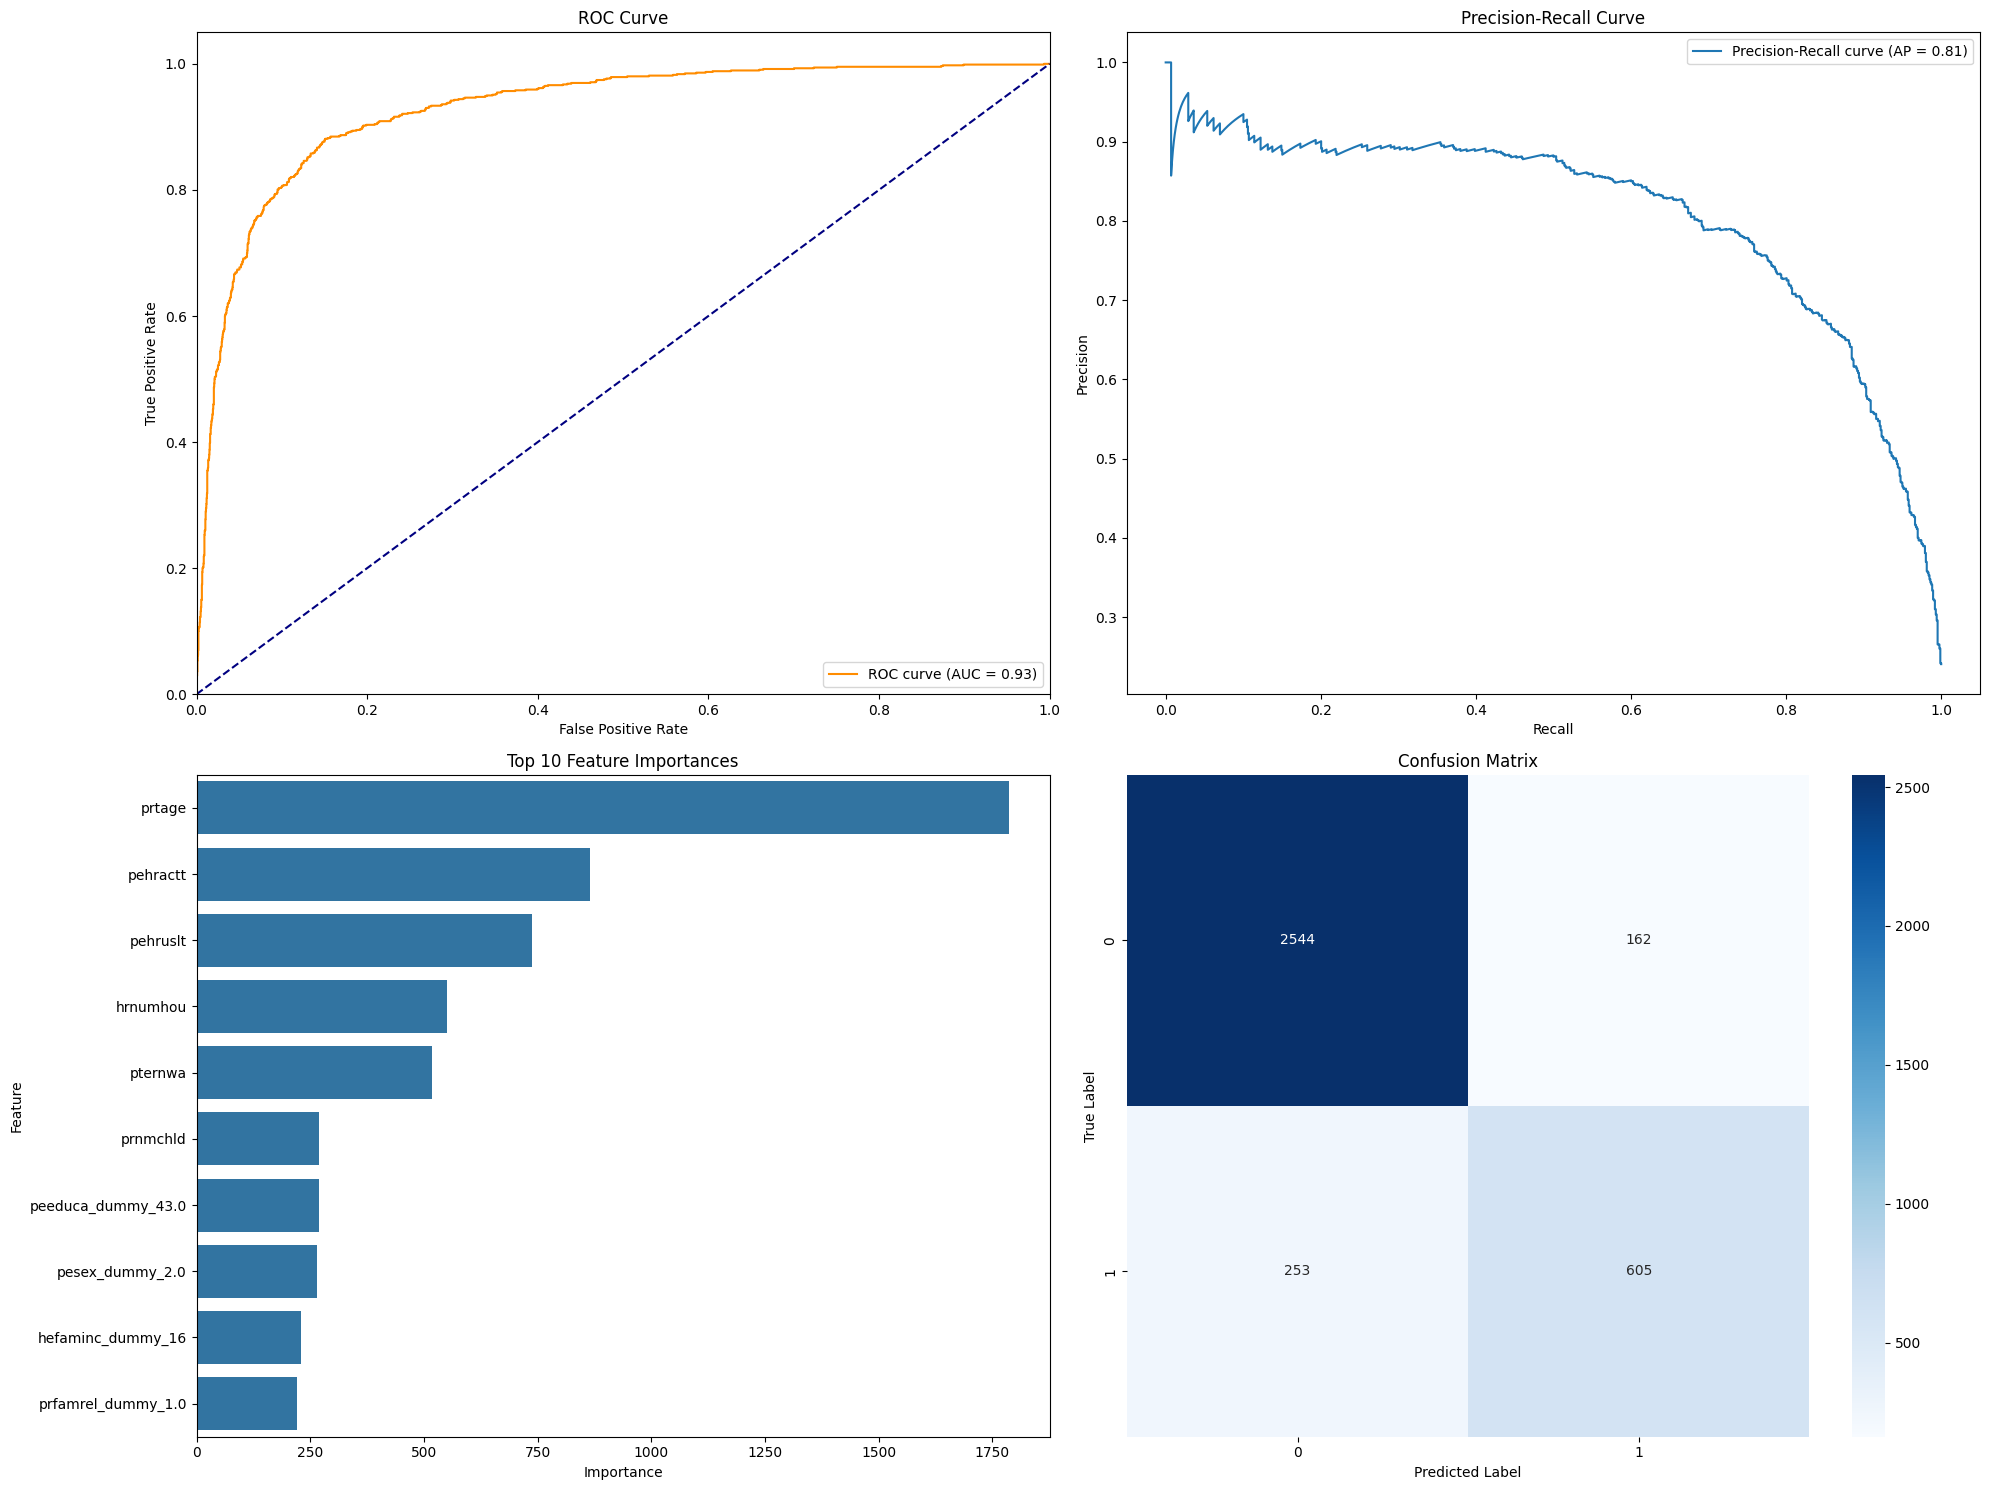


Generating SHAP values...


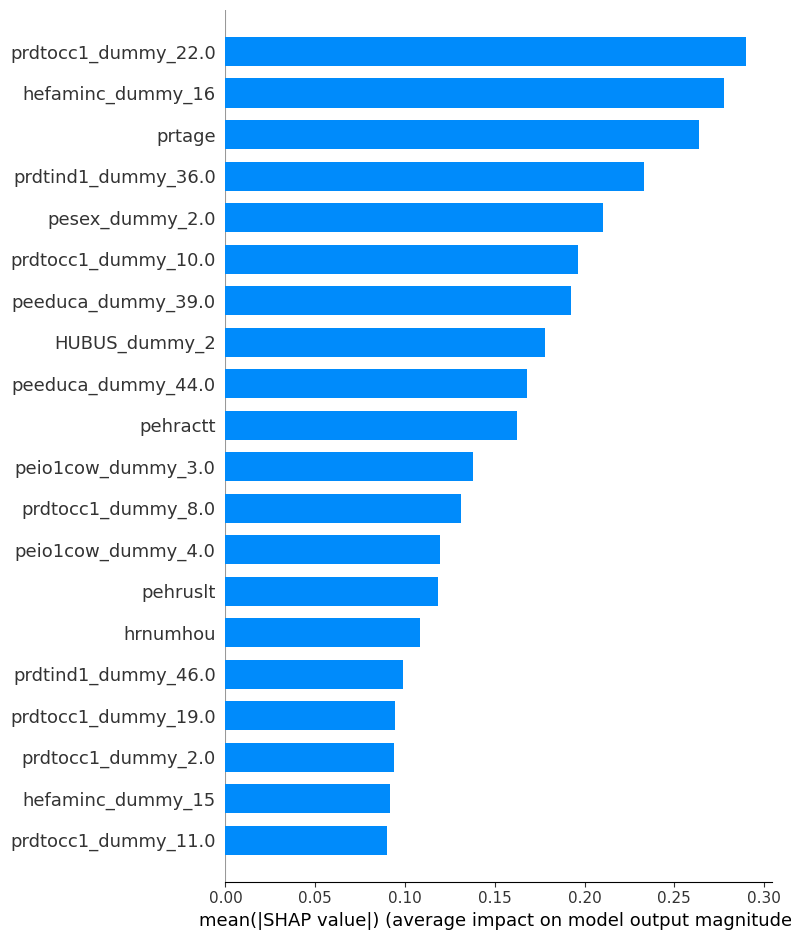

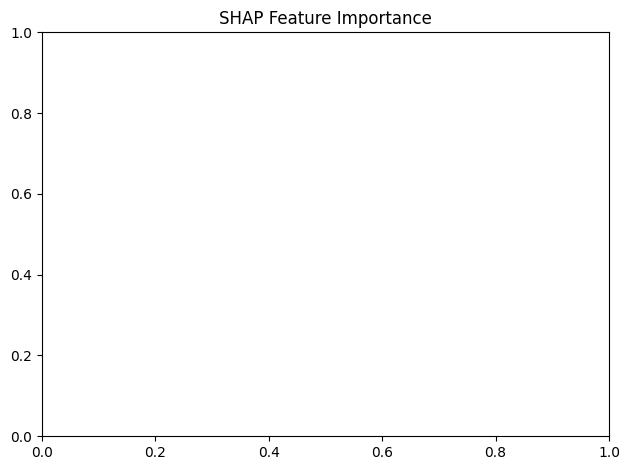

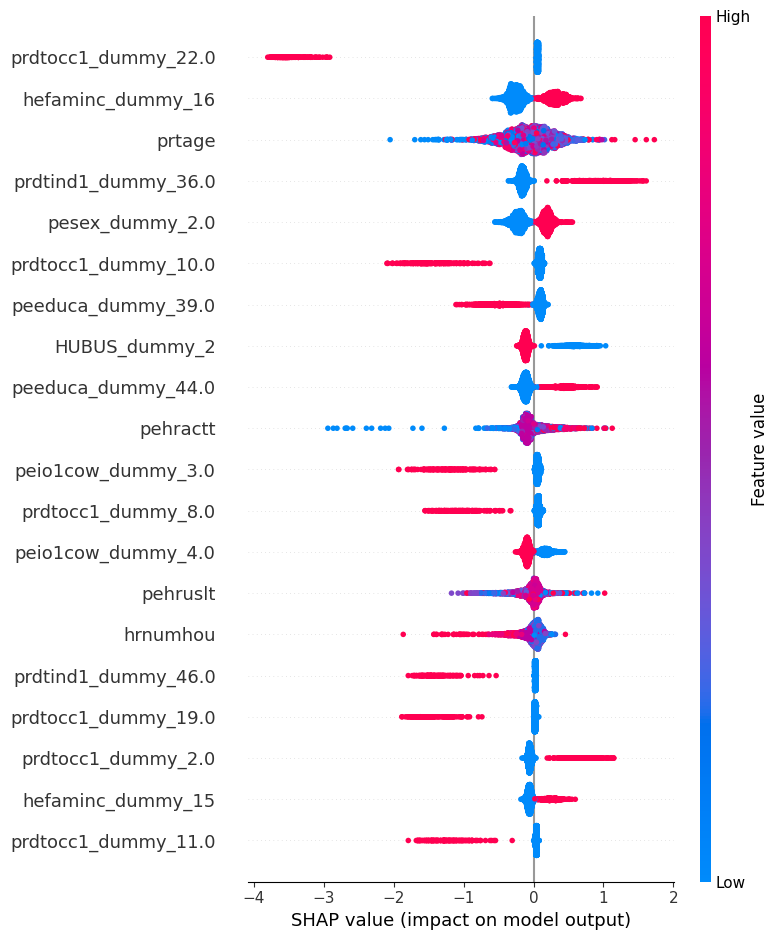

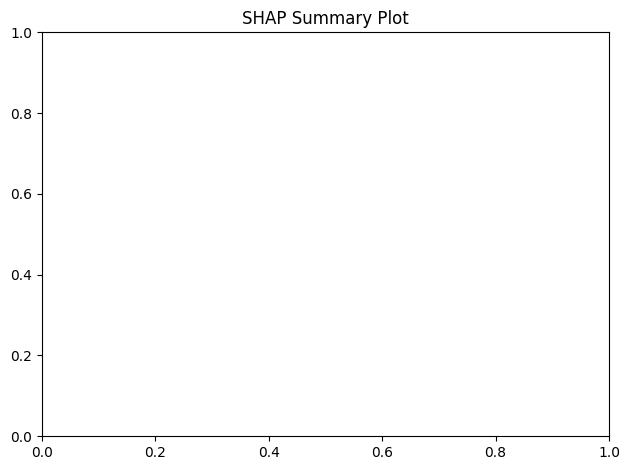

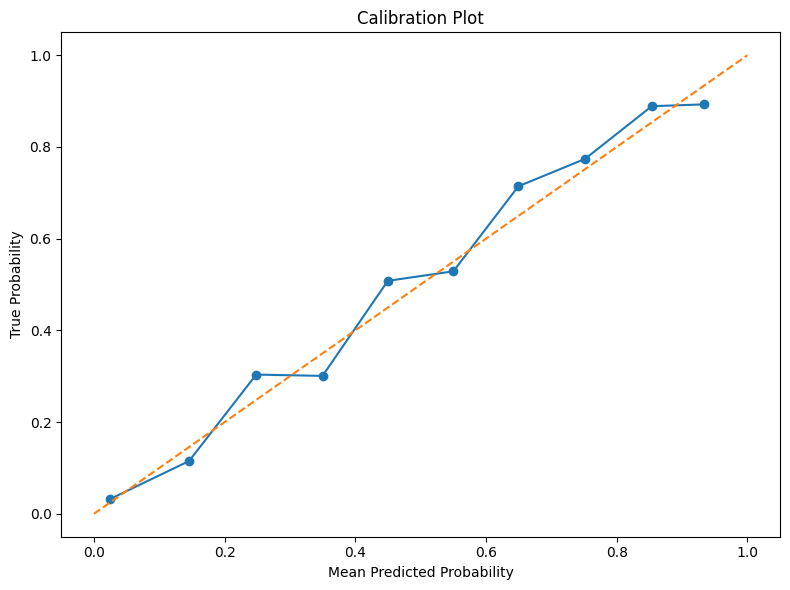

In [ ]:
#| label: results
# Additional Metrics
print("\nCalculating additional performance metrics...")

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate detailed classification metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
total = tn + fp + fn + tp

precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)
f1 = 2 * (precision * recall) / (precision + recall)
prevalence = (tp + fn) / total
negative_predictive_value = tn / (tn + fn)
positive_likelihood_ratio = recall / false_positive_rate
negative_likelihood_ratio = false_negative_rate / specificity

# Print comprehensive metrics
print("\nComprehensive Model Performance Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"\nPrecision: {precision:.4f}")
print(f"Recall/Sensitivity: {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Prevalence: {prevalence:.4f}")
print(f"Negative Predictive Value: {negative_predictive_value:.4f}")
print(f"Positive Likelihood Ratio: {positive_likelihood_ratio:.4f}")
print(f"Negative Likelihood Ratio: {negative_likelihood_ratio:.4f}")

# Create visualizations
plt.figure(figsize=(20, 15))

# Plot 1: ROC Curve
plt.subplot(2, 2, 1)
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='darkorange',
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Plot 2: Precision-Recall Curve
plt.subplot(2, 2, 2)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)
plt.plot(recall_curve, precision_curve,
         label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# Plot 3: Feature Importance
plt.subplot(2, 2, 3)
importance = final_model.get_score(importance_type='weight')
importance_df = pd.DataFrame(list(importance.items()),
                           columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances')

# Plot 4: Confusion Matrix Heatmap
plt.subplot(2, 2, 4)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# SHAP Analysis
print("\nGenerating SHAP values...")
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test)
plt.title('SHAP Summary Plot')
plt.tight_layout()
plt.show()

# Calibration plot
plt.figure(figsize=(8, 6))
prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Plot')
plt.tight_layout()
plt.show()